In [21]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

# Load the dataset
file_path = r"E:\ML-Rework\Accidents_2015.csv"
df = pd.read_csv(file_path)
df_copy = df.copy() 

Creating visualizations...


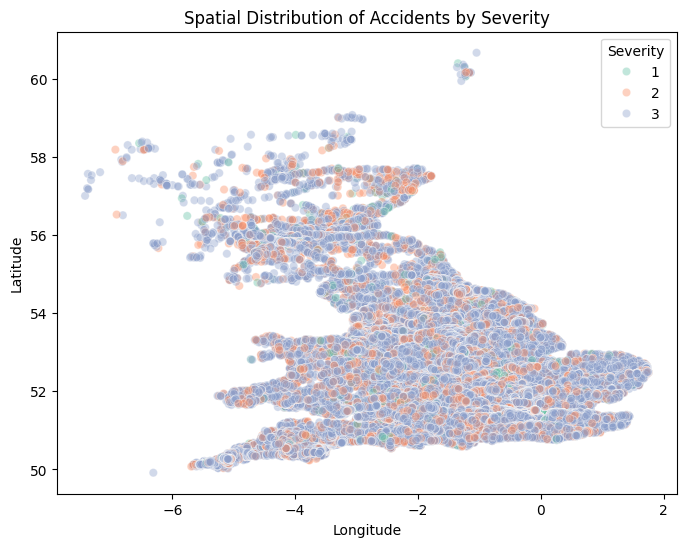

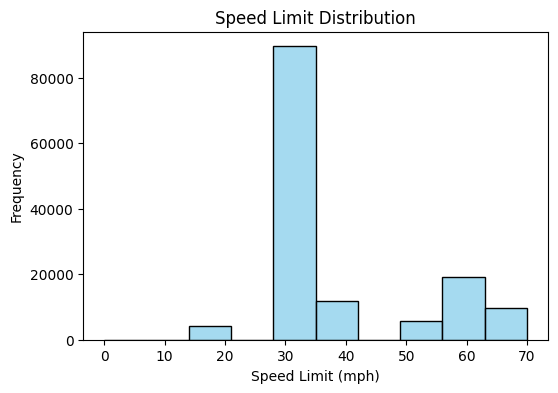

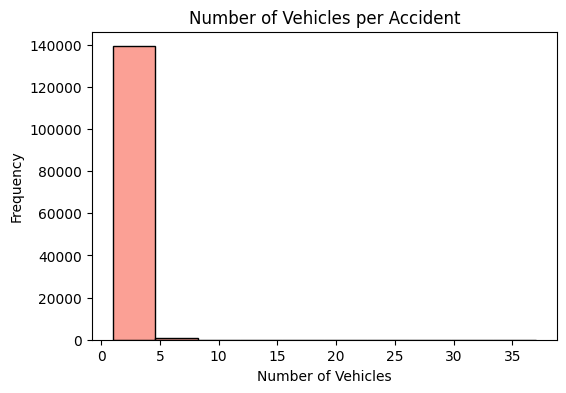

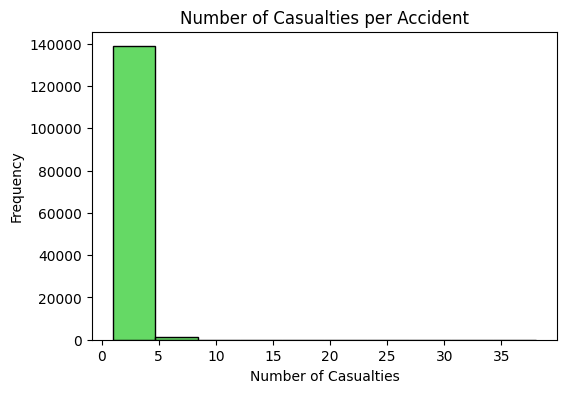

<Figure size 800x400 with 0 Axes>

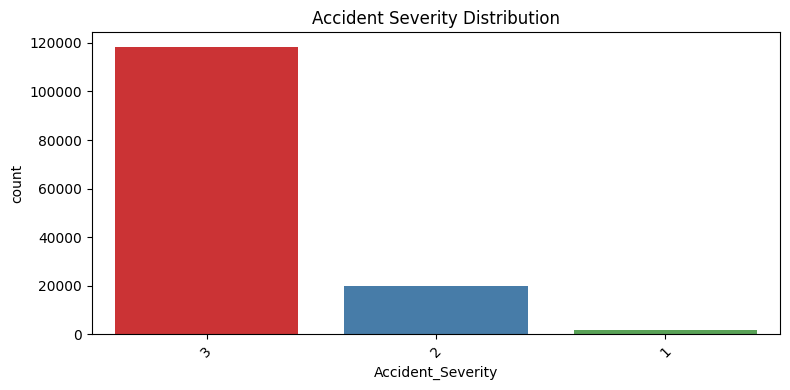

<Figure size 800x400 with 0 Axes>

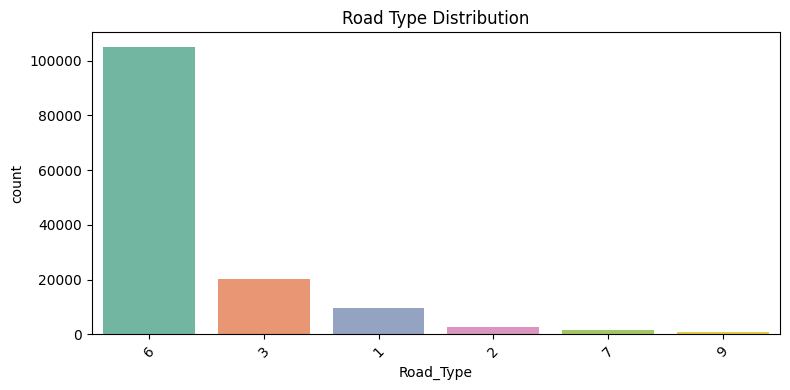

<Figure size 800x400 with 0 Axes>

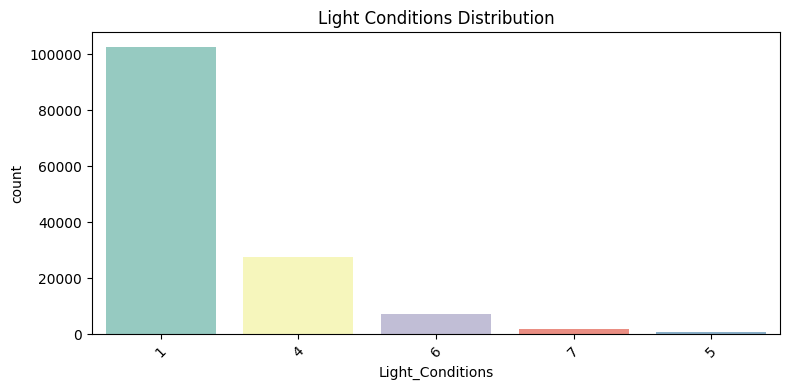

<Figure size 800x400 with 0 Axes>

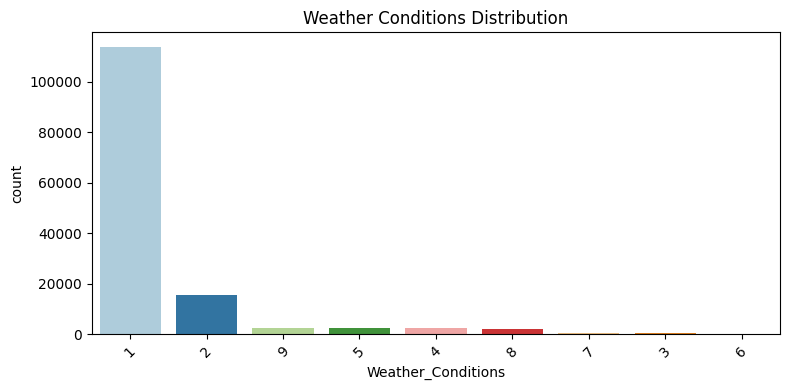

<Figure size 800x400 with 0 Axes>

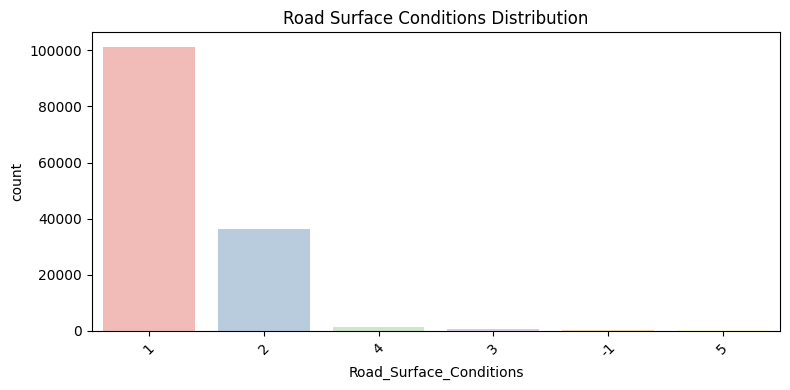

<Figure size 800x400 with 0 Axes>

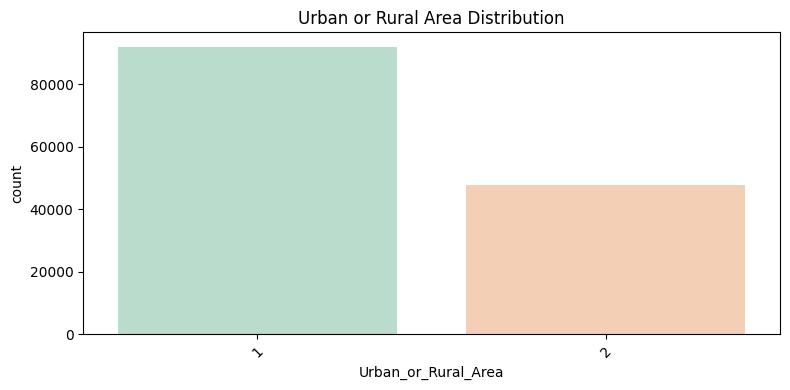

<Figure size 800x400 with 0 Axes>

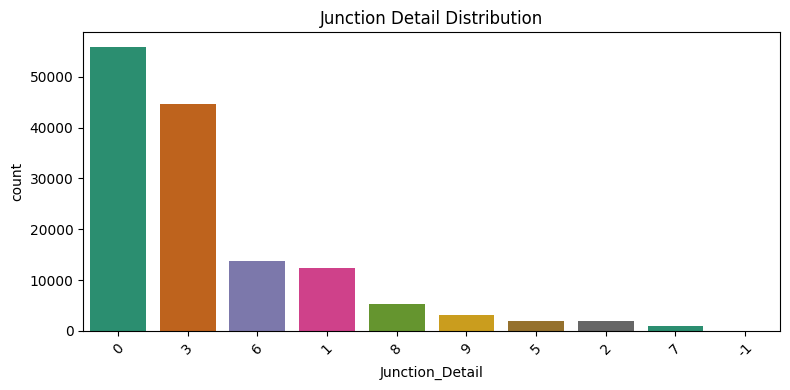

<Figure size 800x400 with 0 Axes>

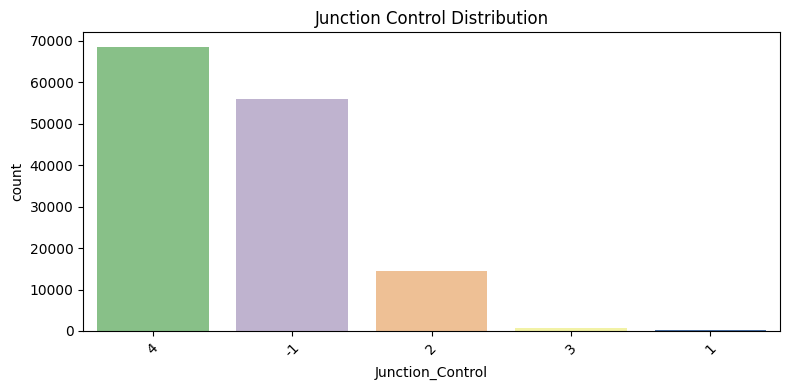

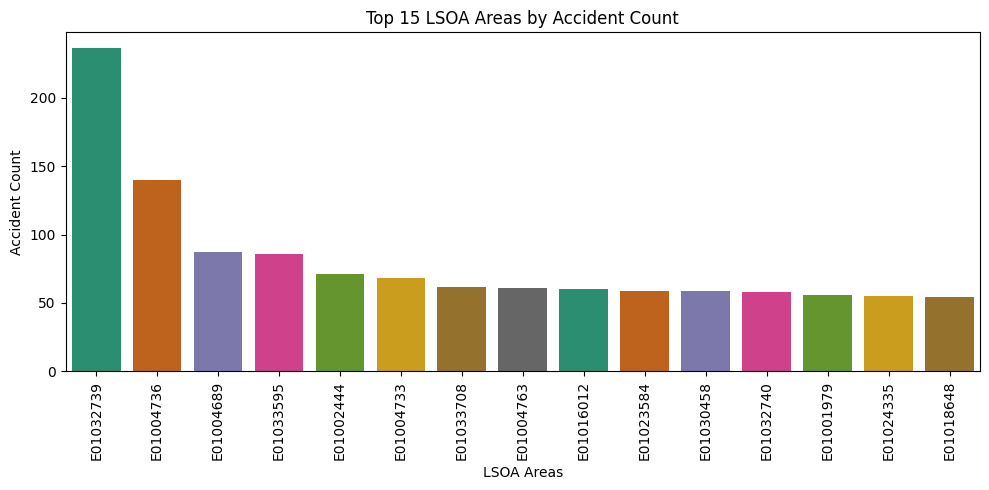

In [22]:
# Define custom colors and palettes for visual distinction
custom_colors = [
    "skyblue", "salmon", "limegreen", "gold", "violet", "coral",
    "deepskyblue", "orange", "mediumseagreen", "orchid"
]
custom_palettes = [
    "Set1", "Set2", "Set3", "Paired", "Pastel1", "Pastel2", "Dark2", "Accent"
]

# ===== VISUALIZATION SECTION =====
print("Creating visualizations...")

# 1. Latitude vs Longitude (Severity color scatter)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Longitude", y="Latitude", hue="Accident_Severity", palette="Set2", alpha=0.4)
plt.title("Spatial Distribution of Accidents by Severity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Severity")
plt.show()

# 2. Speed Limit Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["Speed_limit"], color="skyblue", kde=False, bins=10)
plt.title("Speed Limit Distribution")
plt.xlabel("Speed Limit (mph)")
plt.ylabel("Frequency")
plt.show()

# 3. Number of Vehicles
plt.figure(figsize=(6,4))
sns.histplot(df["Number_of_Vehicles"], color="salmon", kde=False, bins=10)
plt.title("Number of Vehicles per Accident")
plt.xlabel("Number of Vehicles")
plt.ylabel("Frequency")
plt.show()

# 4. Number of Casualties
plt.figure(figsize=(6,4))
sns.histplot(df["Number_of_Casualties"], color="limegreen", kde=False, bins=10)
plt.title("Number of Casualties per Accident")
plt.xlabel("Number of Casualties")
plt.ylabel("Frequency")
plt.show()

# 5. Countplots for categorical features with varied palettes
categorical_features = [
    "Accident_Severity",
    "Road_Type",
    "Light_Conditions",
    "Weather_Conditions",
    "Road_Surface_Conditions",
    "Urban_or_Rural_Area",
    "Junction_Detail",
    "Junction_Control"
]

for i, feature in enumerate(categorical_features):
    plt.figure(figsize=(8,4))
    palette = custom_palettes[i % len(custom_palettes)]
    
    # Check if the feature exists in the dataframe
    if feature in df.columns:
        # Handle potential missing values for the plot
        feature_data = df[feature].dropna()
        if len(feature_data) > 0:
            plt.figure(figsize=(8,4))
            order = feature_data.value_counts().index
            sns.countplot(data=df, x=feature, palette=palette, order=order)
            plt.title(f"{feature.replace('_', ' ')} Distribution")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: {feature} has no valid data for plotting")
    else:
        print(f"Warning: {feature} not found in dataset")

# 6. LSOA Heatmap (Top Areas by Accident Count)
if 'LSOA_of_Accident_Location' in df.columns:
    top_lsoas = df['LSOA_of_Accident_Location'].value_counts().head(15)
    plt.figure(figsize=(10,5))
    sns.barplot(x=range(len(top_lsoas)), y=top_lsoas.values, palette="Dark2")
    plt.title("Top 15 LSOA Areas by Accident Count")
    plt.ylabel("Accident Count")
    plt.xlabel("LSOA Areas")
    plt.xticks(range(len(top_lsoas)), top_lsoas.index, rotation=90)
    plt.tight_layout()
    plt.show()

In [23]:
# ===== CREATE TARGET VARIABLE =====
print("Creating target variable...")

required_cols = ['Local_Authority_(Highway)', 'Accident_Severity']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"Error: Missing required columns: {missing_cols}")
    print(f"Available columns: {df.columns.tolist()}")
else:
    # Define accident-prone label
    grouped = df.groupby('Local_Authority_(Highway)').agg({'Accident_Severity': ['count', 'mean']})
    grouped.columns = ['Total', 'Avg_Severity']
    grouped['Score'] = grouped['Total'] * grouped['Avg_Severity']
    thresh = grouped['Score'].mean()
    prone = grouped[grouped['Score'] > thresh].index

    # Create the target variable
    df['Accident_Prone'] = df['Local_Authority_(Highway)'].apply(lambda x: 1 if x in prone else 0)

    # Verify target variable creation
    print("Target variable created successfully!")
    print(df[['Local_Authority_(Highway)', 'Accident_Prone']].head())
    print("Class distribution:\n", df['Accident_Prone'].value_counts())

Creating target variable...
Target variable created successfully!
  Local_Authority_(Highway)  Accident_Prone
0                 E09000020               0
1                 E09000020               0
2                 E09000020               0
3                 E09000020               0
4                 E09000020               0
Class distribution:
 Accident_Prone
1    95212
0    44844
Name: count, dtype: int64


In [24]:
# ===== FEATURE SELECTION AND ENCODING =====
print("\nSelecting and encoding features...")

# Select relevant columns
base_features = [
    "Location_Easting_OSGR",
    "Location_Northing_OSGR",
    "Longitude",
    "Latitude",
    "Number_of_Vehicles",
    "Number_of_Casualties",
    "Road_Type",
    "Speed_limit",
    "Light_Conditions",
    "Weather_Conditions",
    "Road_Surface_Conditions",
    "Urban_or_Rural_Area",
    "LSOA_of_Accident_Location",
    "Junction_Detail",
    "Junction_Control",
    "Accident_Prone"
]

selected_features = [col for col in base_features if col in df.columns]
missing_features = [col for col in base_features if col not in df.columns]

if missing_features:
    print(f"Warning: The following features are not in the dataset: {missing_features}")

print(f"Selected features: {selected_features}")

# Filter dataset to selected features
df_filtered = df[selected_features].copy()

categorical_columns = [
    "Road_Type",
    "Light_Conditions", 
    "Weather_Conditions",
    "Road_Surface_Conditions",
    "Urban_or_Rural_Area",
    "LSOA_of_Accident_Location",
    "Junction_Detail",
    "Junction_Control"
]

# Only keep categorical columns that exist in the filtered dataframe
categorical_columns = [col for col in categorical_columns if col in df_filtered.columns]

# Initialize dictionary to store encoders
label_encoders = {}

# Apply label encoding
for col in categorical_columns:
    le = LabelEncoder()
    # Handle missing values before encoding
    df_filtered[col] = df_filtered[col].fillna('Unknown')
    df_filtered[col] = le.fit_transform(df_filtered[col].astype(str))
    label_encoders[col] = le

print("Feature encoding completed!")


Selecting and encoding features...
Selected features: ['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 'Road_Type', 'Speed_limit', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'LSOA_of_Accident_Location', 'Junction_Detail', 'Junction_Control', 'Accident_Prone']
Feature encoding completed!


In [25]:
# ===== HANDLE MISSING VALUES =====
print("\nChecking for missing values...")

# Check for missing values in the dataset
missing_values = df_filtered.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Handle missing values
print("\nHandling missing values...")

# For numerical columns, fill with median
numerical_columns = [
    "Location_Easting_OSGR",
    "Location_Northing_OSGR", 
    "Longitude",
    "Latitude",
    "Number_of_Vehicles",
    "Number_of_Casualties",
    "Speed_limit"
]

# Only process numerical columns that exist in the dataframe
numerical_columns = [col for col in numerical_columns if col in df_filtered.columns]

for col in numerical_columns:
    if df_filtered[col].isnull().sum() > 0:
        median_val = df_filtered[col].median()
        df_filtered[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val}")

# For categorical columns (already encoded), fill with mode (most frequent value)
for col in categorical_columns:
    if col in df_filtered.columns and df_filtered[col].isnull().sum() > 0:
        mode_val = df_filtered[col].mode()[0]
        df_filtered[col].fillna(mode_val, inplace=True)
        print(f"Filled {col} missing values with mode: {mode_val}")

# Verify no missing values remain
remaining_missing = df_filtered.isnull().sum().sum()
print(f"\nTotal remaining missing values: {remaining_missing}")



Checking for missing values...
Missing values per column:
Location_Easting_OSGR     27
Location_Northing_OSGR    27
Longitude                 27
Latitude                  27
dtype: int64

Handling missing values...
Filled Location_Easting_OSGR missing values with median: 451460.0
Filled Location_Northing_OSGR missing values with median: 240886.0
Filled Longitude missing values with median: -1.236156
Filled Latitude missing values with median: 52.051875

Total remaining missing values: 0


In [26]:
# ===== PREPARE DATA FOR SAMPLING =====
print("\nPreparing data for sampling...")

if 'Accident_Prone' not in df_filtered.columns:
    print("Error: Target variable 'Accident_Prone' not found!")
else:
    # Separate features and target
    X = df_filtered.drop('Accident_Prone', axis=1)
    y = df_filtered['Accident_Prone']
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")
    
    # ===== CURRENT DATA ANALYSIS =====
    print("\nCurrent class distribution analysis:")
    print("Before any sampling:", Counter(y))
    print(f"Class 0 (Non-accident-prone): {Counter(y)[0]} samples")
    print(f"Class 1 (Accident-prone): {Counter(y)[1]} samples")
    
    if Counter(y)[1] > 0:  # Avoid division by zero
        print(f"Imbalance ratio: {Counter(y)[0]/Counter(y)[1]:.2f}:1")
    
    # ===== STRATEGY 1: COMBINED SMOTE + UNDERSAMPLING =====
    print("\n" + "="*50)
    print("STRATEGY 1: SMOTE + Random Undersampling")
    print("="*50)
    
    try:
        # Calculate target samples based on current distribution
        current_counts = Counter(y)
        minority_class = min(current_counts, key=current_counts.get)
        majority_class = max(current_counts, key=current_counts.get)
        
        # First apply SMOTE to increase minority class
        target_minority_samples = min(70000, current_counts[majority_class])  # Don't oversample beyond majority
        
        smote = SMOTE(
            sampling_strategy={minority_class: target_minority_samples}, 
            random_state=42
        )
        X_smote, y_smote = smote.fit_resample(X, y)
        print("After SMOTE:", Counter(y_smote))
        
        # Then apply undersampling to reduce majority class
        current_counts_smote = Counter(y_smote)
        target_majority_samples = min(75000, current_counts_smote[majority_class])
        
        undersampler = RandomUnderSampler(
            sampling_strategy={majority_class: target_majority_samples},
            random_state=42
        )
        X_balanced_1, y_balanced_1 = undersampler.fit_resample(X_smote, y_smote)
        
        print("After Undersampling:", Counter(y_balanced_1))
        final_counts = Counter(y_balanced_1)
        if final_counts[majority_class] > 0:
            print(f"Final ratio {minority_class}:{majority_class} = {final_counts[minority_class]/final_counts[majority_class]:.2f}:1")
            
        print("\nBalanced dataset created successfully!")
        print(f"Final balanced dataset shape: {X_balanced_1.shape}")
        
    except Exception as e:
        print(f"Error during sampling: {str(e)}")
        print("Please check your data and sampling parameters.")

print("\nScript completed successfully!")


Preparing data for sampling...
Feature matrix shape: (140056, 15)
Target vector shape: (140056,)

Current class distribution analysis:
Before any sampling: Counter({1: 95212, 0: 44844})
Class 0 (Non-accident-prone): 44844 samples
Class 1 (Accident-prone): 95212 samples
Imbalance ratio: 0.47:1

STRATEGY 1: SMOTE + Random Undersampling
After SMOTE: Counter({1: 95212, 0: 70000})
After Undersampling: Counter({1: 75000, 0: 70000})
Final ratio 0:1 = 0.93:1

Balanced dataset created successfully!
Final balanced dataset shape: (145000, 15)

Script completed successfully!


Creating post-SMOTE visualizations...

ORIGINAL DATA VISUALIZATION FORMAT - BEFORE vs AFTER SMOTE COMPARISON


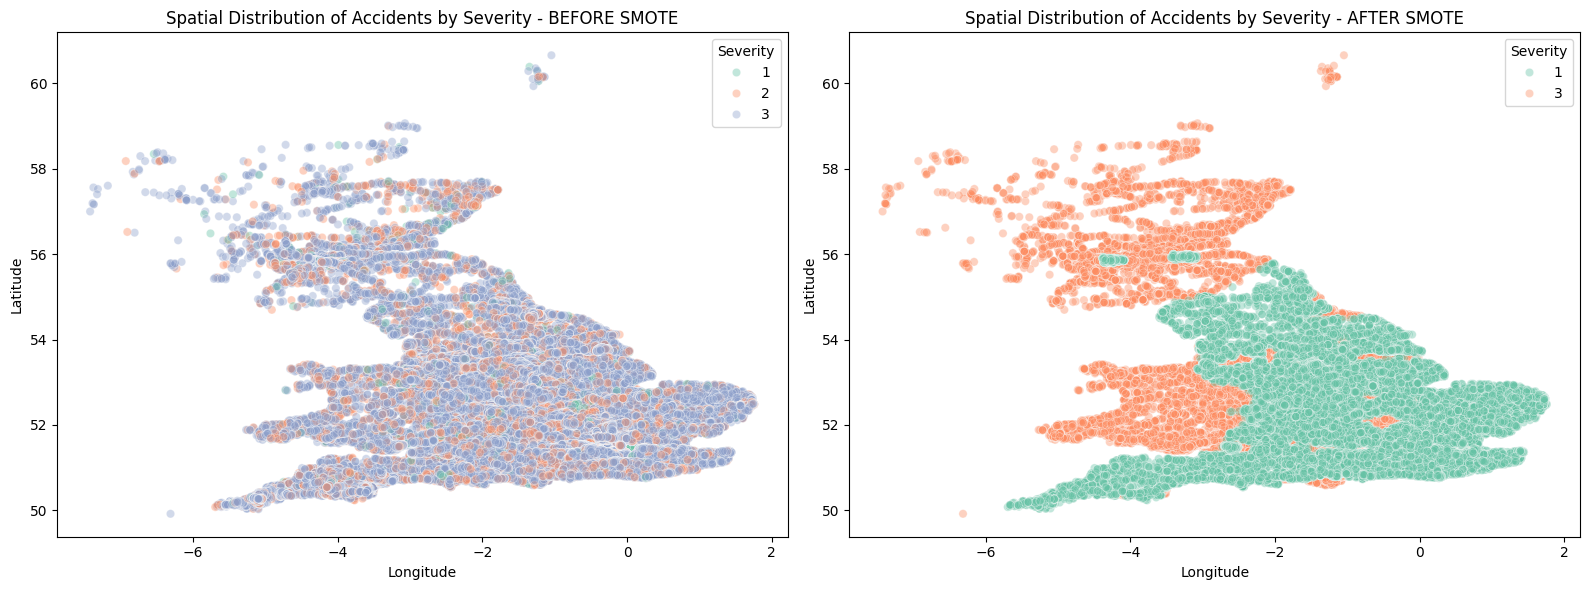

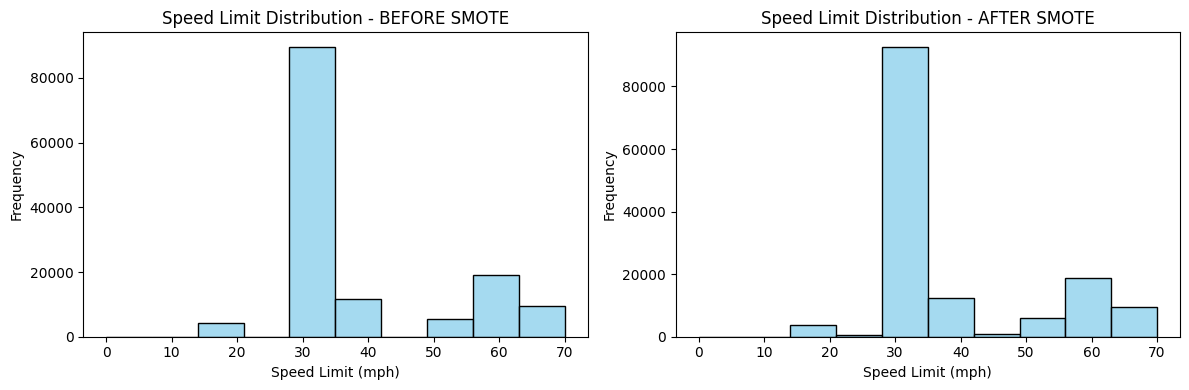

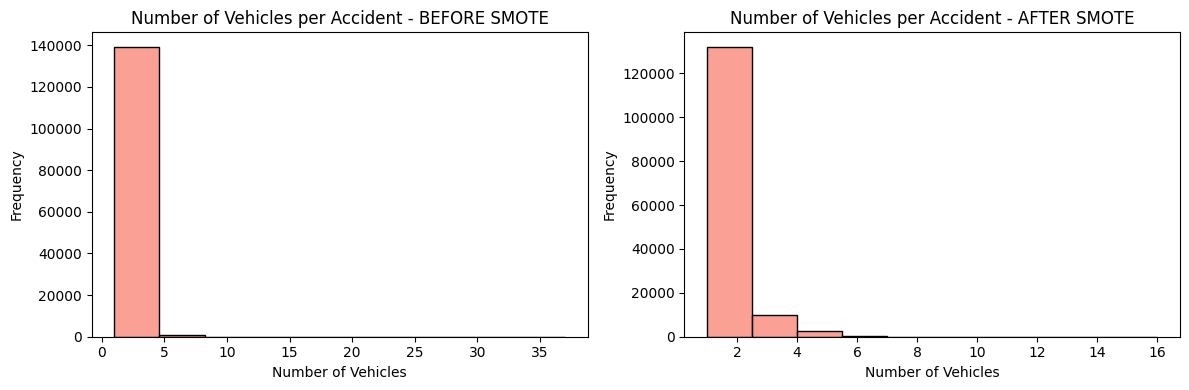

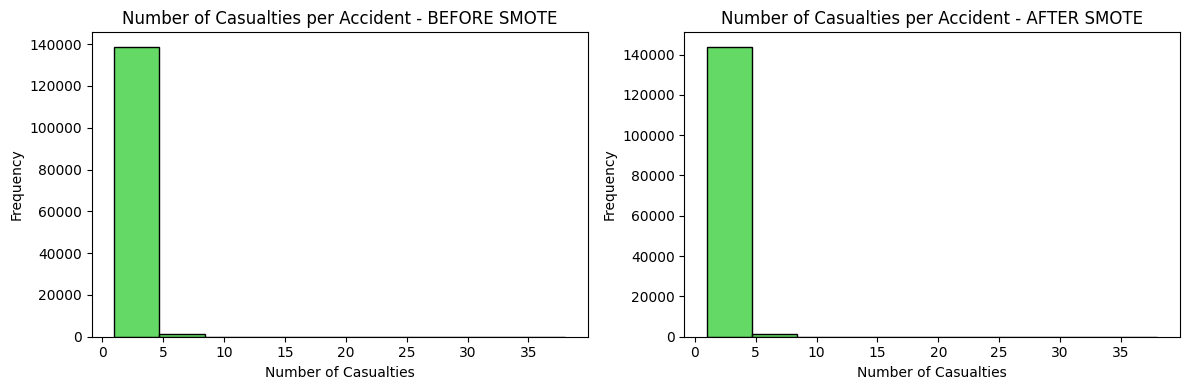

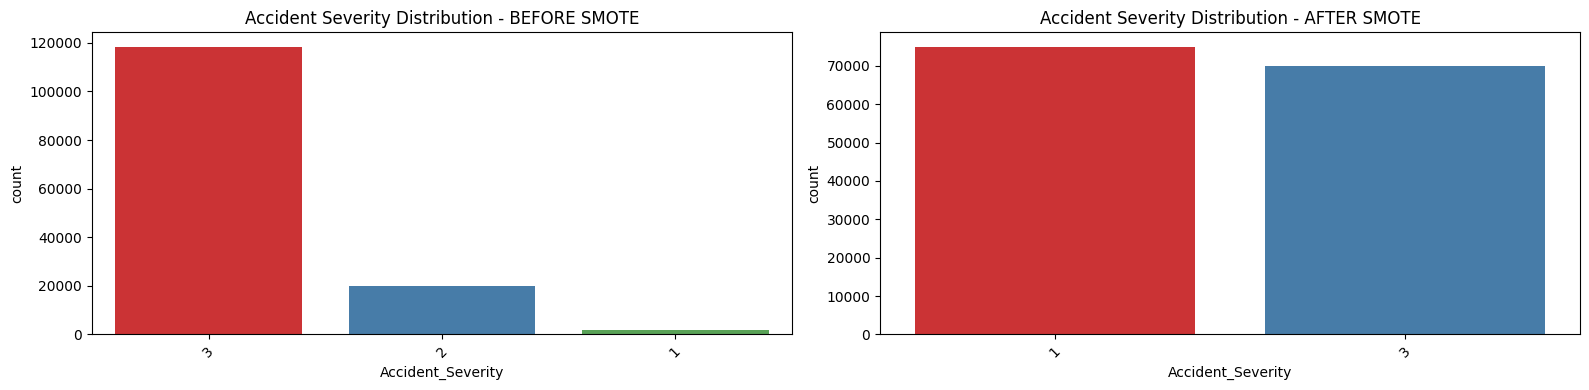

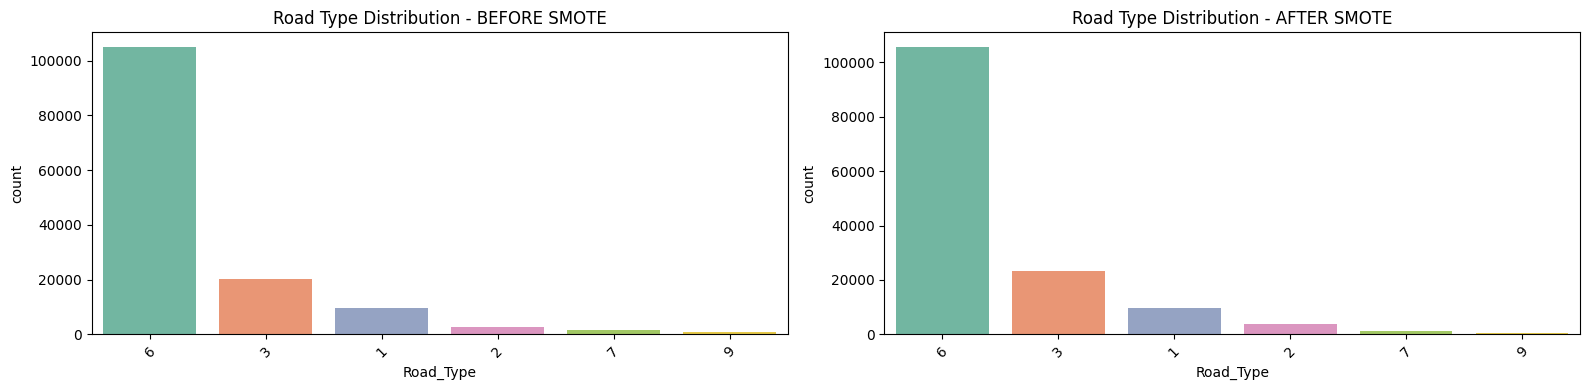

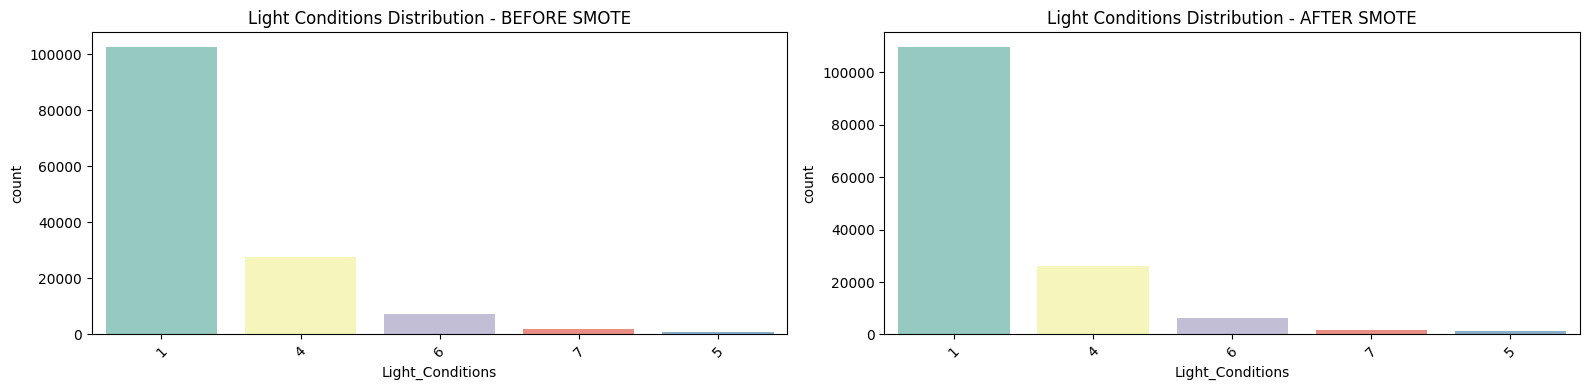

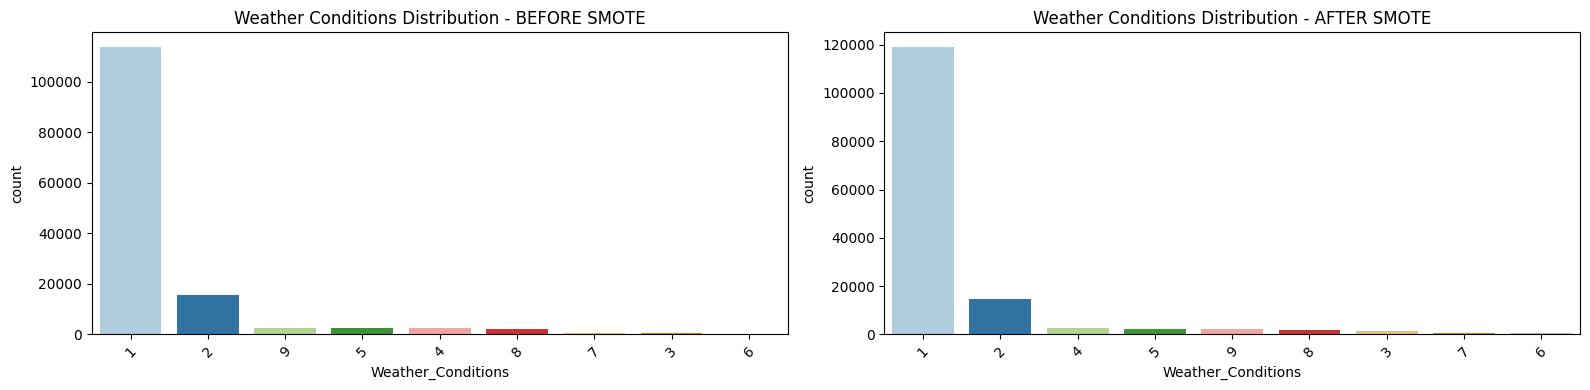

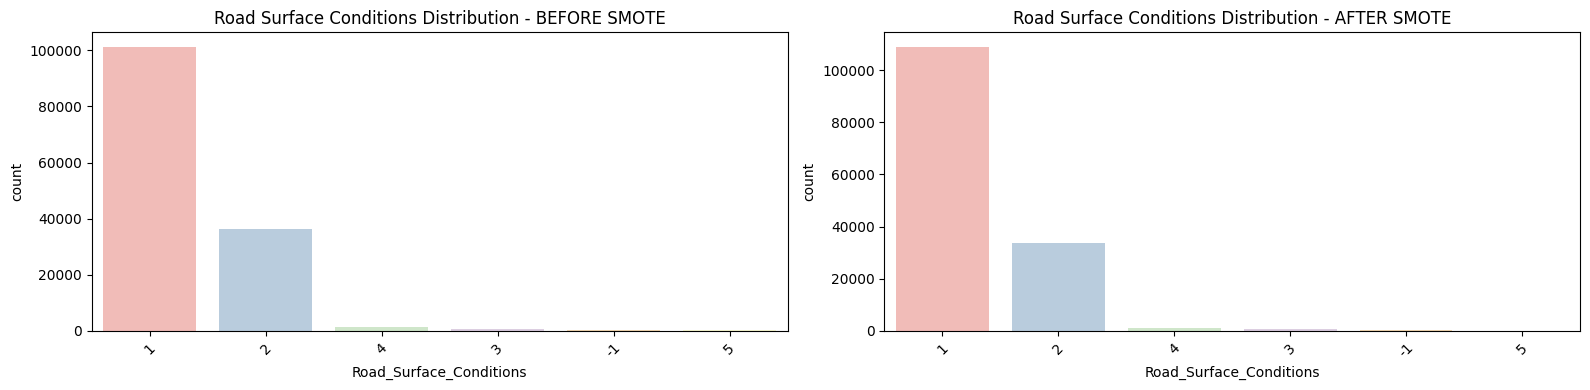

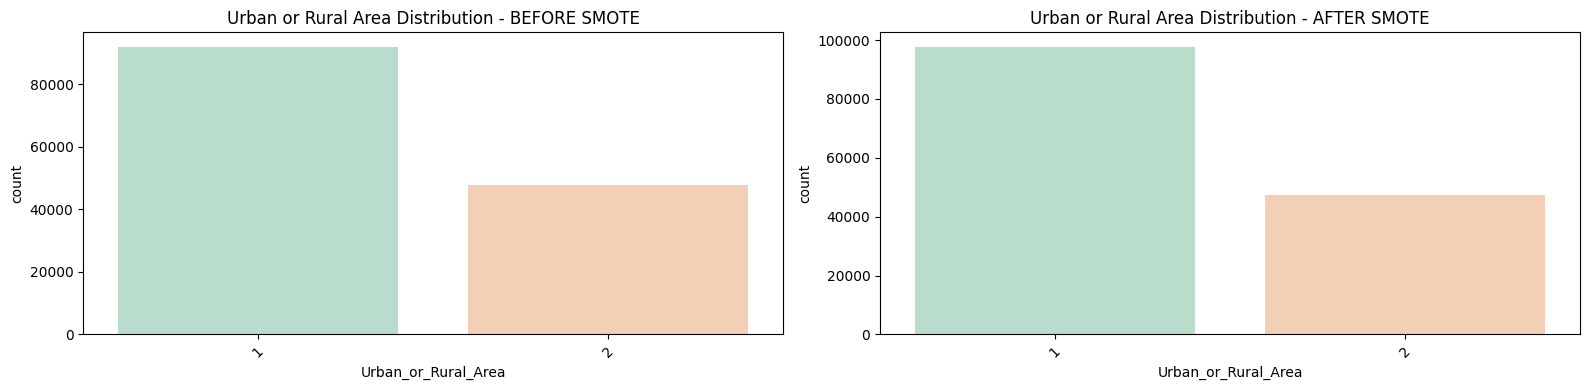

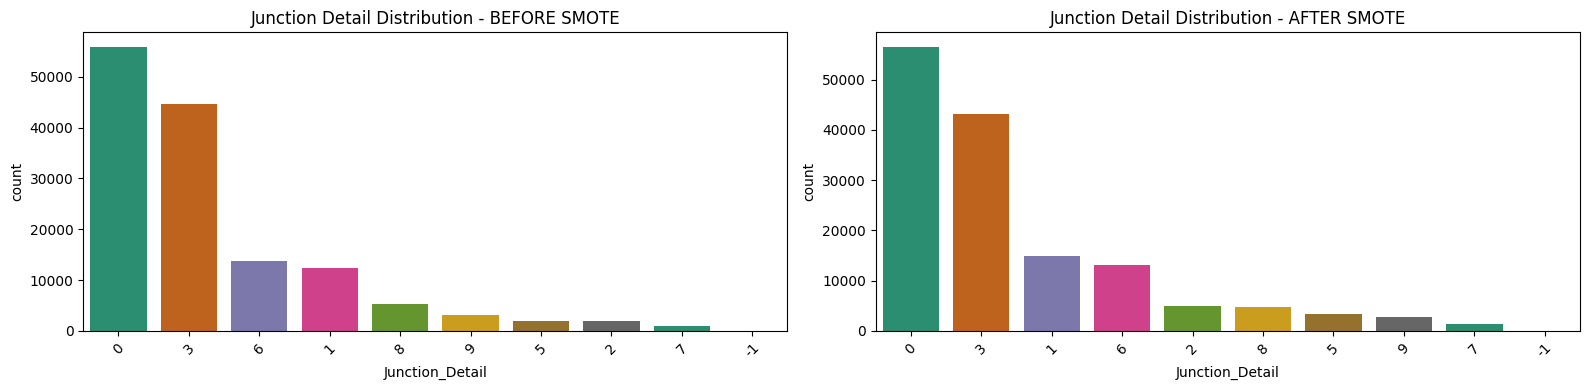

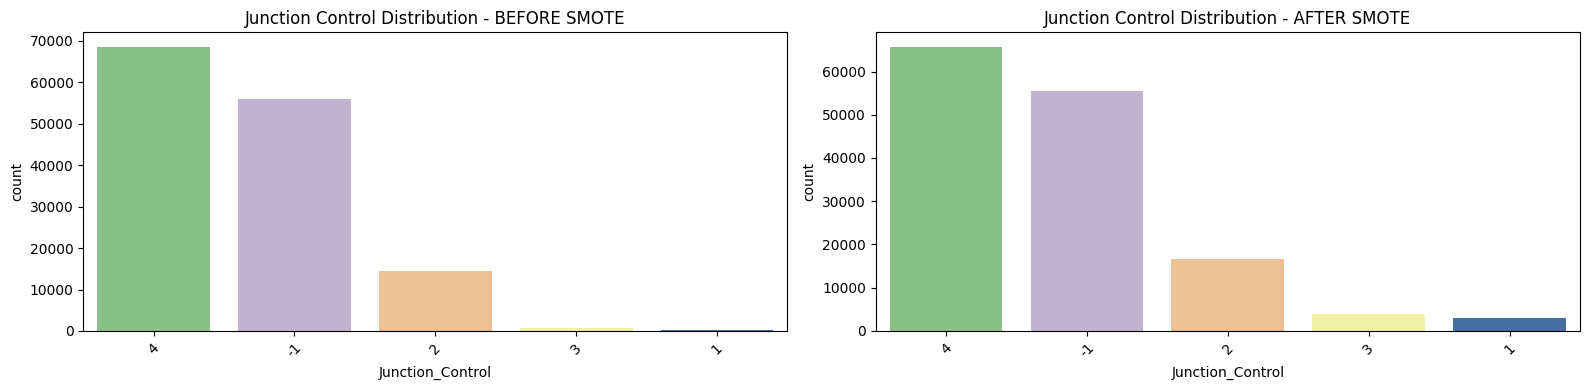

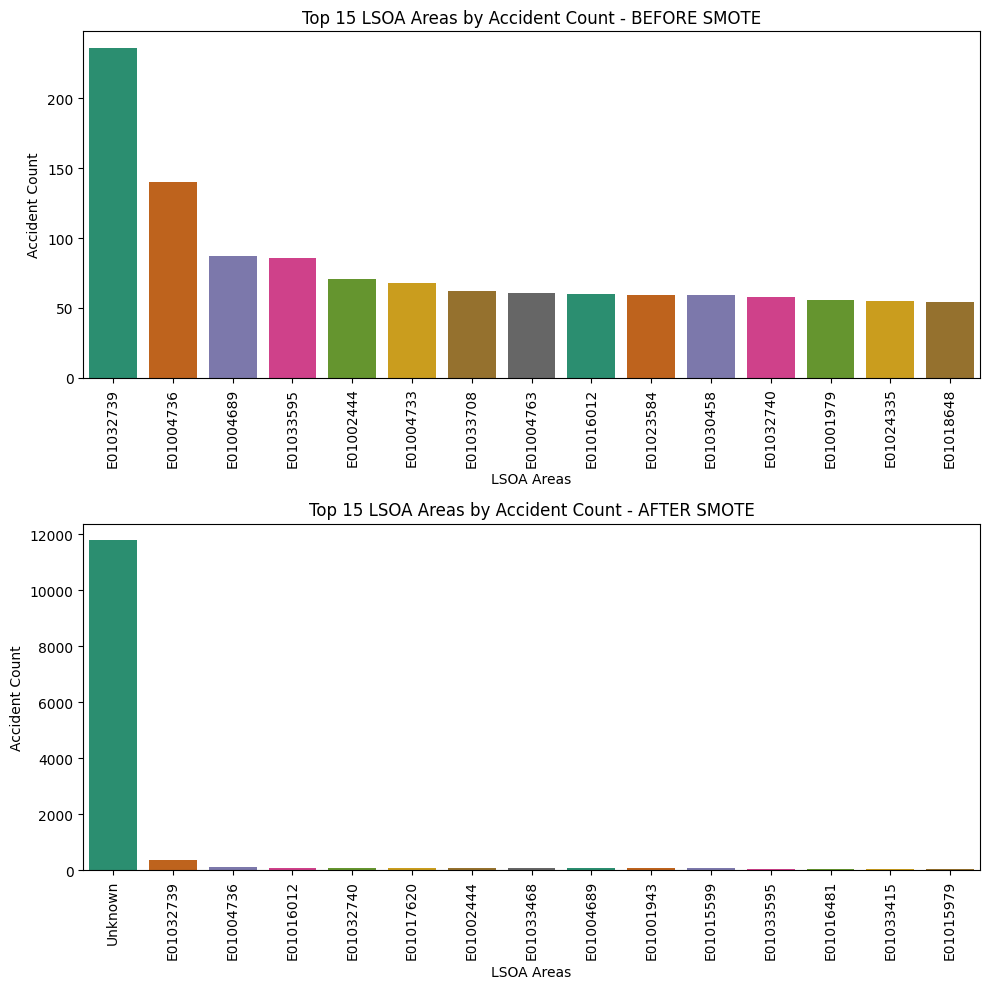


TARGET VARIABLE COMPARISON


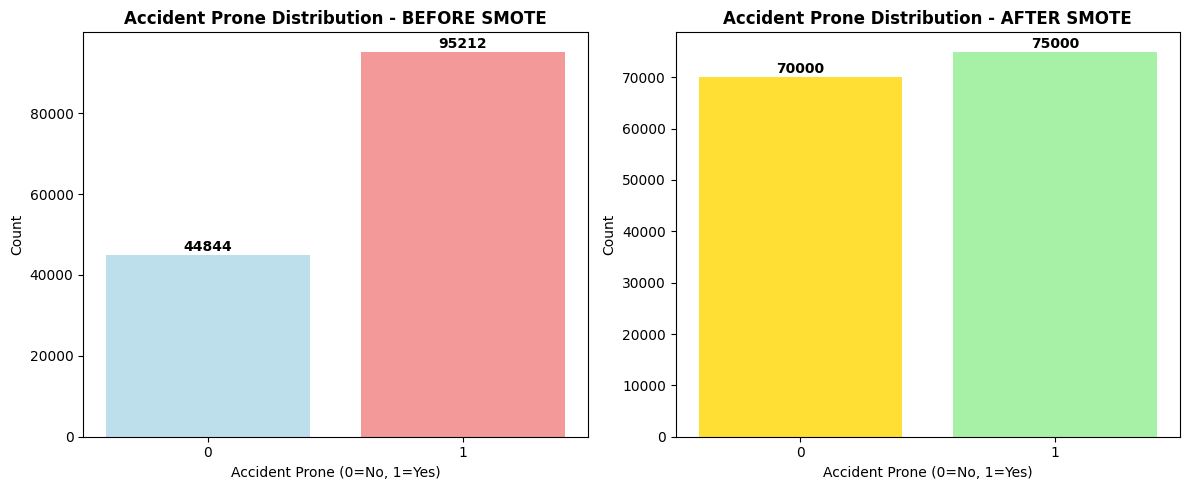


DATASET COMPARISON SUMMARY
Original dataset size: 140056
Balanced dataset size: 145000
Original class distribution: {0: 44844, 1: 95212}
Balanced class distribution: {0: 70000, 1: 75000}
Original imbalance ratio: 2.12:1
Balanced imbalance ratio: 1.07:1

Numerical Features Summary Comparison:

Number_of_Vehicles:
  BEFORE SMOTE - Mean: 1.84, Std: 0.71
  AFTER SMOTE  - Mean: 1.79, Std: 0.69

Number_of_Casualties:
  BEFORE SMOTE - Mean: 1.33, Std: 0.80
  AFTER SMOTE  - Mean: 1.30, Std: 0.76

Speed_limit:
  BEFORE SMOTE - Mean: 38.18, Std: 13.90
  AFTER SMOTE  - Mean: 38.00, Std: 13.66

VISUALIZATION COMPLETE!


In [27]:
# Post-SMOTE Data Visualization Code
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Define custom colors and palettes for visual distinction
custom_colors = [
    "skyblue", "salmon", "limegreen", "gold", "violet", "coral",
    "deepskyblue", "orange", "mediumseagreen", "orchid"
]
custom_palettes = [
    "Set1", "Set2", "Set3", "Paired", "Pastel1", "Pastel2", "Dark2", "Accent"
]

# ===== RECREATE DATAFRAME FROM BALANCED DATA =====
print("Creating post-SMOTE visualizations...")

# Convert balanced arrays back to DataFrame for visualization
df_balanced = pd.DataFrame(X_balanced_1, columns=X.columns)
df_balanced['Accident_Prone'] = y_balanced_1

# Decode categorical variables back to original labels for better visualization
def decode_categorical_features(df_balanced, label_encoders):
    """Decode categorical features back to original labels"""
    df_decoded = df_balanced.copy()
    
    for col, encoder in label_encoders.items():
        if col in df_decoded.columns:
            try:
                # Handle potential out-of-range values from SMOTE
                encoded_values = df_decoded[col].astype(int)
                max_encoded = len(encoder.classes_) - 1
                
                # Clip values to valid range
                encoded_values = np.clip(encoded_values, 0, max_encoded)
                
                # Decode back to original labels
                df_decoded[col] = encoder.inverse_transform(encoded_values)
            except Exception as e:
                print(f"Warning: Could not decode {col}: {e}")
                # Keep original encoded values if decoding fails
                pass
    
    return df_decoded

# Create decoded dataframe for visualization
df_balanced_decoded = decode_categorical_features(df_balanced, label_encoders)

# Add Accident_Severity back for spatial visualization (using most common severity for new samples)
if 'Accident_Severity' not in df_balanced_decoded.columns:
    # For new synthetic samples, assign accident severity based on accident_prone status
    # You can modify this logic based on your domain knowledge
    df_balanced_decoded['Accident_Severity'] = df_balanced_decoded['Accident_Prone'].map({0: 3, 1: 1})

print("\n" + "="*80)
print("ORIGINAL DATA VISUALIZATION FORMAT - BEFORE vs AFTER SMOTE COMPARISON")
print("="*80)

# ===== 1. LATITUDE vs LONGITUDE (SEVERITY COLOR SCATTER) - BEFORE vs AFTER =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# BEFORE SMOTE
if all(col in df.columns for col in ["Longitude", "Latitude", "Accident_Severity"]):
    sns.scatterplot(data=df, x="Longitude", y="Latitude", hue="Accident_Severity", 
                   palette="Set2", alpha=0.4, ax=ax1)
    ax1.set_title("Spatial Distribution of Accidents by Severity - BEFORE SMOTE")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.legend(title="Severity")

# AFTER SMOTE
sns.scatterplot(data=df_balanced_decoded, x="Longitude", y="Latitude", hue="Accident_Severity", 
               palette="Set2", alpha=0.4, ax=ax2)
ax2.set_title("Spatial Distribution of Accidents by Severity - AFTER SMOTE")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.legend(title="Severity")

plt.tight_layout()
plt.show()

# ===== 2. SPEED LIMIT DISTRIBUTION - BEFORE vs AFTER =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# BEFORE SMOTE
if "Speed_limit" in df.columns:
    sns.histplot(df["Speed_limit"], color="skyblue", kde=False, bins=10, ax=ax1)
    ax1.set_title("Speed Limit Distribution - BEFORE SMOTE")
    ax1.set_xlabel("Speed Limit (mph)")
    ax1.set_ylabel("Frequency")

# AFTER SMOTE
sns.histplot(df_balanced["Speed_limit"], color="skyblue", kde=False, bins=10, ax=ax2)
ax2.set_title("Speed Limit Distribution - AFTER SMOTE")
ax2.set_xlabel("Speed Limit (mph)")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# ===== 3. NUMBER OF VEHICLES - BEFORE vs AFTER =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# BEFORE SMOTE
if "Number_of_Vehicles" in df.columns:
    sns.histplot(df["Number_of_Vehicles"], color="salmon", kde=False, bins=10, ax=ax1)
    ax1.set_title("Number of Vehicles per Accident - BEFORE SMOTE")
    ax1.set_xlabel("Number of Vehicles")
    ax1.set_ylabel("Frequency")

# AFTER SMOTE
sns.histplot(df_balanced["Number_of_Vehicles"], color="salmon", kde=False, bins=10, ax=ax2)
ax2.set_title("Number of Vehicles per Accident - AFTER SMOTE")
ax2.set_xlabel("Number of Vehicles")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# ===== 4. NUMBER OF CASUALTIES - BEFORE vs AFTER =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# BEFORE SMOTE
if "Number_of_Casualties" in df.columns:
    sns.histplot(df["Number_of_Casualties"], color="limegreen", kde=False, bins=10, ax=ax1)
    ax1.set_title("Number of Casualties per Accident - BEFORE SMOTE")
    ax1.set_xlabel("Number of Casualties")
    ax1.set_ylabel("Frequency")

# AFTER SMOTE
sns.histplot(df_balanced["Number_of_Casualties"], color="limegreen", kde=False, bins=10, ax=ax2)
ax2.set_title("Number of Casualties per Accident - AFTER SMOTE")
ax2.set_xlabel("Number of Casualties")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# ===== 5. COUNTPLOTS FOR CATEGORICAL FEATURES - BEFORE vs AFTER =====
categorical_features = [
    "Accident_Severity",
    "Road_Type",
    "Light_Conditions",
    "Weather_Conditions",
    "Road_Surface_Conditions",
    "Urban_or_Rural_Area",
    "Junction_Detail",
    "Junction_Control"
]

for i, feature in enumerate(categorical_features):
    if feature in df_balanced_decoded.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
        palette = custom_palettes[i % len(custom_palettes)]
        
        # BEFORE SMOTE
        if feature in df.columns:
            before_order = df[feature].value_counts().index
            sns.countplot(data=df, x=feature, palette=palette, order=before_order, ax=ax1)
            ax1.set_title(f"{feature.replace('_', ' ')} Distribution - BEFORE SMOTE")
            ax1.tick_params(axis='x', rotation=45)
        
        # AFTER SMOTE
        after_order = df_balanced_decoded[feature].value_counts().index
        sns.countplot(data=df_balanced_decoded, x=feature, palette=palette, order=after_order, ax=ax2)
        ax2.set_title(f"{feature.replace('_', ' ')} Distribution - AFTER SMOTE")
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

# ===== 6. LSOA HEATMAP (TOP AREAS BY ACCIDENT COUNT) - BEFORE vs AFTER =====
if 'LSOA_of_Accident_Location' in df_balanced_decoded.columns:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    # BEFORE SMOTE
    if 'LSOA_of_Accident_Location' in df.columns:
        top_lsoas_before = df['LSOA_of_Accident_Location'].value_counts().head(15)
        sns.barplot(x=range(len(top_lsoas_before)), y=top_lsoas_before.values, 
                   palette="Dark2", ax=ax1)
        ax1.set_title("Top 15 LSOA Areas by Accident Count - BEFORE SMOTE")
        ax1.set_ylabel("Accident Count")
        ax1.set_xlabel("LSOA Areas")
        ax1.set_xticks(range(len(top_lsoas_before)))
        ax1.set_xticklabels(top_lsoas_before.index, rotation=90)
    
    # AFTER SMOTE
    top_lsoas_after = df_balanced_decoded['LSOA_of_Accident_Location'].value_counts().head(15)
    sns.barplot(x=range(len(top_lsoas_after)), y=top_lsoas_after.values, 
               palette="Dark2", ax=ax2)
    ax2.set_title("Top 15 LSOA Areas by Accident Count - AFTER SMOTE")
    ax2.set_ylabel("Accident Count")
    ax2.set_xlabel("LSOA Areas")
    ax2.set_xticks(range(len(top_lsoas_after)))
    ax2.set_xticklabels(top_lsoas_after.index, rotation=90)
    
    plt.tight_layout()
    plt.show()

# ===== 7. TARGET VARIABLE (ACCIDENT_PRONE) COMPARISON =====
print("\n" + "="*60)
print("TARGET VARIABLE COMPARISON")
print("="*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# BEFORE SMOTE
if 'Accident_Prone' in df.columns:
    before_counts = df['Accident_Prone'].value_counts()
    colors_before = ['lightcoral', 'lightblue']
    ax1.bar(before_counts.index, before_counts.values, color=colors_before, alpha=0.8)
    ax1.set_title('Accident Prone Distribution - BEFORE SMOTE', fontweight='bold')
    ax1.set_xlabel('Accident Prone (0=No, 1=Yes)')
    ax1.set_ylabel('Count')
    ax1.set_xticks([0, 1])
    for i, v in enumerate(before_counts.values):
        ax1.text(before_counts.index[i], v + max(before_counts.values)*0.01, str(v), 
                ha='center', fontweight='bold')

# AFTER SMOTE
after_counts = df_balanced['Accident_Prone'].value_counts()
colors_after = ['lightgreen', 'gold']
ax2.bar(after_counts.index, after_counts.values, color=colors_after, alpha=0.8)
ax2.set_title('Accident Prone Distribution - AFTER SMOTE', fontweight='bold')
ax2.set_xlabel('Accident Prone (0=No, 1=Yes)')
ax2.set_ylabel('Count')
ax2.set_xticks([0, 1])
for i, v in enumerate(after_counts.values):
    ax2.text(after_counts.index[i], v + max(after_counts.values)*0.01, str(v), 
            ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ===== 8. ADDITIONAL COMPARISON METRICS =====
print("\n" + "="*60)
print("DATASET COMPARISON SUMMARY")
print("="*60)

print(f"Original dataset size: {len(df) if 'df' in globals() else 'N/A'}")
print(f"Balanced dataset size: {len(df_balanced)}")

if 'y' in globals():
    print(f"Original class distribution: {dict(Counter(y))}")
print(f"Balanced class distribution: {dict(Counter(y_balanced_1))}")

# Calculate and display class balance ratios
if 'y' in globals():
    original_counts = Counter(y)
    if min(original_counts.values()) > 0:
        original_ratio = max(original_counts.values()) / min(original_counts.values())
        print(f"Original imbalance ratio: {original_ratio:.2f}:1")

balanced_counts = Counter(y_balanced_1)
if min(balanced_counts.values()) > 0:
    balanced_ratio = max(balanced_counts.values()) / min(balanced_counts.values())
    print(f"Balanced imbalance ratio: {balanced_ratio:.2f}:1")

# Feature statistics comparison
print("\nNumerical Features Summary Comparison:")
numerical_features = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']
for feature in numerical_features:
    if feature in df_balanced.columns:
        print(f"\n{feature}:")
        print(f"  BEFORE SMOTE - Mean: {df[feature].mean():.2f}, Std: {df[feature].std():.2f}" 
              if feature in df.columns else "  BEFORE SMOTE - Feature not available")
        print(f"  AFTER SMOTE  - Mean: {df_balanced[feature].mean():.2f}, Std: {df_balanced[feature].std():.2f}")

print("\n" + "="*60)
print("VISUALIZATION COMPLETE!")
print("="*60)

In [28]:
# Best ML Algorithms for Accident-Prone Area Prediction
# Based on your balanced dataset with SMOTE

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# ===== ALGORITHM RECOMMENDATIONS =====
print("=" * 80)
print("TOP ML ALGORITHM RECOMMENDATIONS FOR YOUR ACCIDENT DATA")
print("=" * 80)

# Assuming you have X_balanced_1 and y_balanced_1 from the SMOTE process
# Replace with the actual balanced data variables
X = X_balanced_1  # balanced feature matrix
y = y_balanced_1  # balanced target vector

# Split the balanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features for algorithms that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")


TOP ML ALGORITHM RECOMMENDATIONS FOR YOUR ACCIDENT DATA
Training set size: (101500, 15)
Test set size: (43500, 15)
Training class distribution: [49000 52500]


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 1. RANDOM FOREST
print("\n1. RANDOM FOREST")
print("-" * 50)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("**Performance Metrics**")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"Precision: {precision_score(y_test, rf_pred):.4f}")
print(f"Recall: {recall_score(y_test, rf_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, rf_pred):.4f}")

print("\n**Classification Report**")
print(classification_report(y_test, rf_pred))



1. RANDOM FOREST
--------------------------------------------------
**Performance Metrics**
Accuracy: 0.9959
Precision: 0.9962
Recall: 0.9959
F1-Score: 0.9960

**Classification Report**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21000
           1       1.00      1.00      1.00     22500

    accuracy                           1.00     43500
   macro avg       1.00      1.00      1.00     43500
weighted avg       1.00      1.00      1.00     43500



In [30]:
# 2. XGBOOST
print("\n" + "=" * 80)
print("2. XGBOOST")
print("-" * 50)
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("**Performance Metrics**")
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"Precision: {precision_score(y_test, xgb_pred):.4f}")
print(f"Recall: {recall_score(y_test, xgb_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, xgb_pred):.4f}")

print("\n**Classification Report**")
print(classification_report(y_test, xgb_pred))



2. XGBOOST
--------------------------------------------------
**Performance Metrics**
Accuracy: 0.9958
Precision: 0.9957
Recall: 0.9961
F1-Score: 0.9959

**Classification Report**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21000
           1       1.00      1.00      1.00     22500

    accuracy                           1.00     43500
   macro avg       1.00      1.00      1.00     43500
weighted avg       1.00      1.00      1.00     43500



In [31]:
# 3. LIGHTGBM
print("\n" + "=" * 80)
print("3. LIGHTGBM")
print("-" * 50)
lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

print("**Performance Metrics**")
print(f"Accuracy: {accuracy_score(y_test, lgb_pred):.4f}")
print(f"Precision: {precision_score(y_test, lgb_pred):.4f}")
print(f"Recall: {recall_score(y_test, lgb_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, lgb_pred):.4f}")

print("\n**Classification Report**")
print(classification_report(y_test, lgb_pred))


3. LIGHTGBM
--------------------------------------------------
**Performance Metrics**
Accuracy: 0.9931
Precision: 0.9935
Recall: 0.9933
F1-Score: 0.9934

**Classification Report**
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21000
           1       0.99      0.99      0.99     22500

    accuracy                           0.99     43500
   macro avg       0.99      0.99      0.99     43500
weighted avg       0.99      0.99      0.99     43500



In [32]:
# 4. GRADIENT BOOSTING
print("\n" + "=" * 80)
print("4. GRADIENT BOOSTING")
print("-" * 50)
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

print("**Performance Metrics**")
print(f"Accuracy: {accuracy_score(y_test, gb_pred):.4f}")
print(f"Precision: {precision_score(y_test, gb_pred):.4f}")
print(f"Recall: {recall_score(y_test, gb_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, gb_pred):.4f}")

print("\n**Classification Report**")
print(classification_report(y_test, gb_pred))


4. GRADIENT BOOSTING
--------------------------------------------------
**Performance Metrics**
Accuracy: 0.9462
Precision: 0.9528
Recall: 0.9426
F1-Score: 0.9477

**Classification Report**
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     21000
           1       0.95      0.94      0.95     22500

    accuracy                           0.95     43500
   macro avg       0.95      0.95      0.95     43500
weighted avg       0.95      0.95      0.95     43500



In [33]:
# 5. EXTRA TREES
print("\n" + "=" * 80)
print("5. EXTRA TREES")
print("-" * 50)
et = ExtraTreesClassifier(n_estimators=100, random_state=42)
et.fit(X_train, y_train)
et_pred = et.predict(X_test)

print("**Performance Metrics**")
print(f"Accuracy: {accuracy_score(y_test, et_pred):.4f}")
print(f"Precision: {precision_score(y_test, et_pred):.4f}")
print(f"Recall: {recall_score(y_test, et_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, et_pred):.4f}")

print("\n**Classification Report**")
print(classification_report(y_test, et_pred))


5. EXTRA TREES
--------------------------------------------------
**Performance Metrics**
Accuracy: 0.9931
Precision: 0.9932
Recall: 0.9935
F1-Score: 0.9933

**Classification Report**
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21000
           1       0.99      0.99      0.99     22500

    accuracy                           0.99     43500
   macro avg       0.99      0.99      0.99     43500
weighted avg       0.99      0.99      0.99     43500



In [34]:
# 6. NAIVE BAYES
print("\n" + "=" * 80)
print("6. NAIVE BAYES")
print("-" * 50)
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)  # Using scaled data
nb_pred = nb.predict(X_test_scaled)

print("**Performance Metrics**")
print(f"Accuracy: {accuracy_score(y_test, nb_pred):.4f}")
print(f"Precision: {precision_score(y_test, nb_pred):.4f}")
print(f"Recall: {recall_score(y_test, nb_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, nb_pred):.4f}")

print("\n**Classification Report**")
print(classification_report(y_test, nb_pred))


6. NAIVE BAYES
--------------------------------------------------
**Performance Metrics**
Accuracy: 0.6544
Precision: 0.6452
Recall: 0.7372
F1-Score: 0.6881

**Classification Report**
              precision    recall  f1-score   support

           0       0.67      0.57      0.61     21000
           1       0.65      0.74      0.69     22500

    accuracy                           0.65     43500
   macro avg       0.66      0.65      0.65     43500
weighted avg       0.66      0.65      0.65     43500



In [35]:
# 7. NEURAL NETWORK
print("\n" + "=" * 80)
print("7. NEURAL NETWORK")
print("-" * 50)
nn = MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500)
nn.fit(X_train_scaled, y_train)  # Using scaled data
nn_pred = nn.predict(X_test_scaled)

print("**Performance Metrics**")
print(f"Accuracy: {accuracy_score(y_test, nn_pred):.4f}")
print(f"Precision: {precision_score(y_test, nn_pred):.4f}")
print(f"Recall: {recall_score(y_test, nn_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, nn_pred):.4f}")

print("\n**Classification Report**")
print(classification_report(y_test, nn_pred))


7. NEURAL NETWORK
--------------------------------------------------
**Performance Metrics**
Accuracy: 0.9681
Precision: 0.9807
Recall: 0.9572
F1-Score: 0.9688

**Classification Report**
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     21000
           1       0.98      0.96      0.97     22500

    accuracy                           0.97     43500
   macro avg       0.97      0.97      0.97     43500
weighted avg       0.97      0.97      0.97     43500



In [36]:
# 8. LOGISTIC REGRESSION
print("\n" + "=" * 80)
print("8. LOGISTIC REGRESSION")
print("-" * 50)
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)  # Using scaled data
lr_pred = lr.predict(X_test_scaled)

print("**Performance Metrics**")
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"Precision: {precision_score(y_test, lr_pred):.4f}")
print(f"Recall: {recall_score(y_test, lr_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, lr_pred):.4f}")

print("\n**Classification Report**")
print(classification_report(y_test, lr_pred))


8. LOGISTIC REGRESSION
--------------------------------------------------
**Performance Metrics**
Accuracy: 0.6670
Precision: 0.6677
Recall: 0.7091
F1-Score: 0.6878

**Classification Report**
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     21000
           1       0.67      0.71      0.69     22500

    accuracy                           0.67     43500
   macro avg       0.67      0.67      0.67     43500
weighted avg       0.67      0.67      0.67     43500



CONFUSION MATRICES FOR ALL ALGORITHMS (7:3 Train-Test Split)


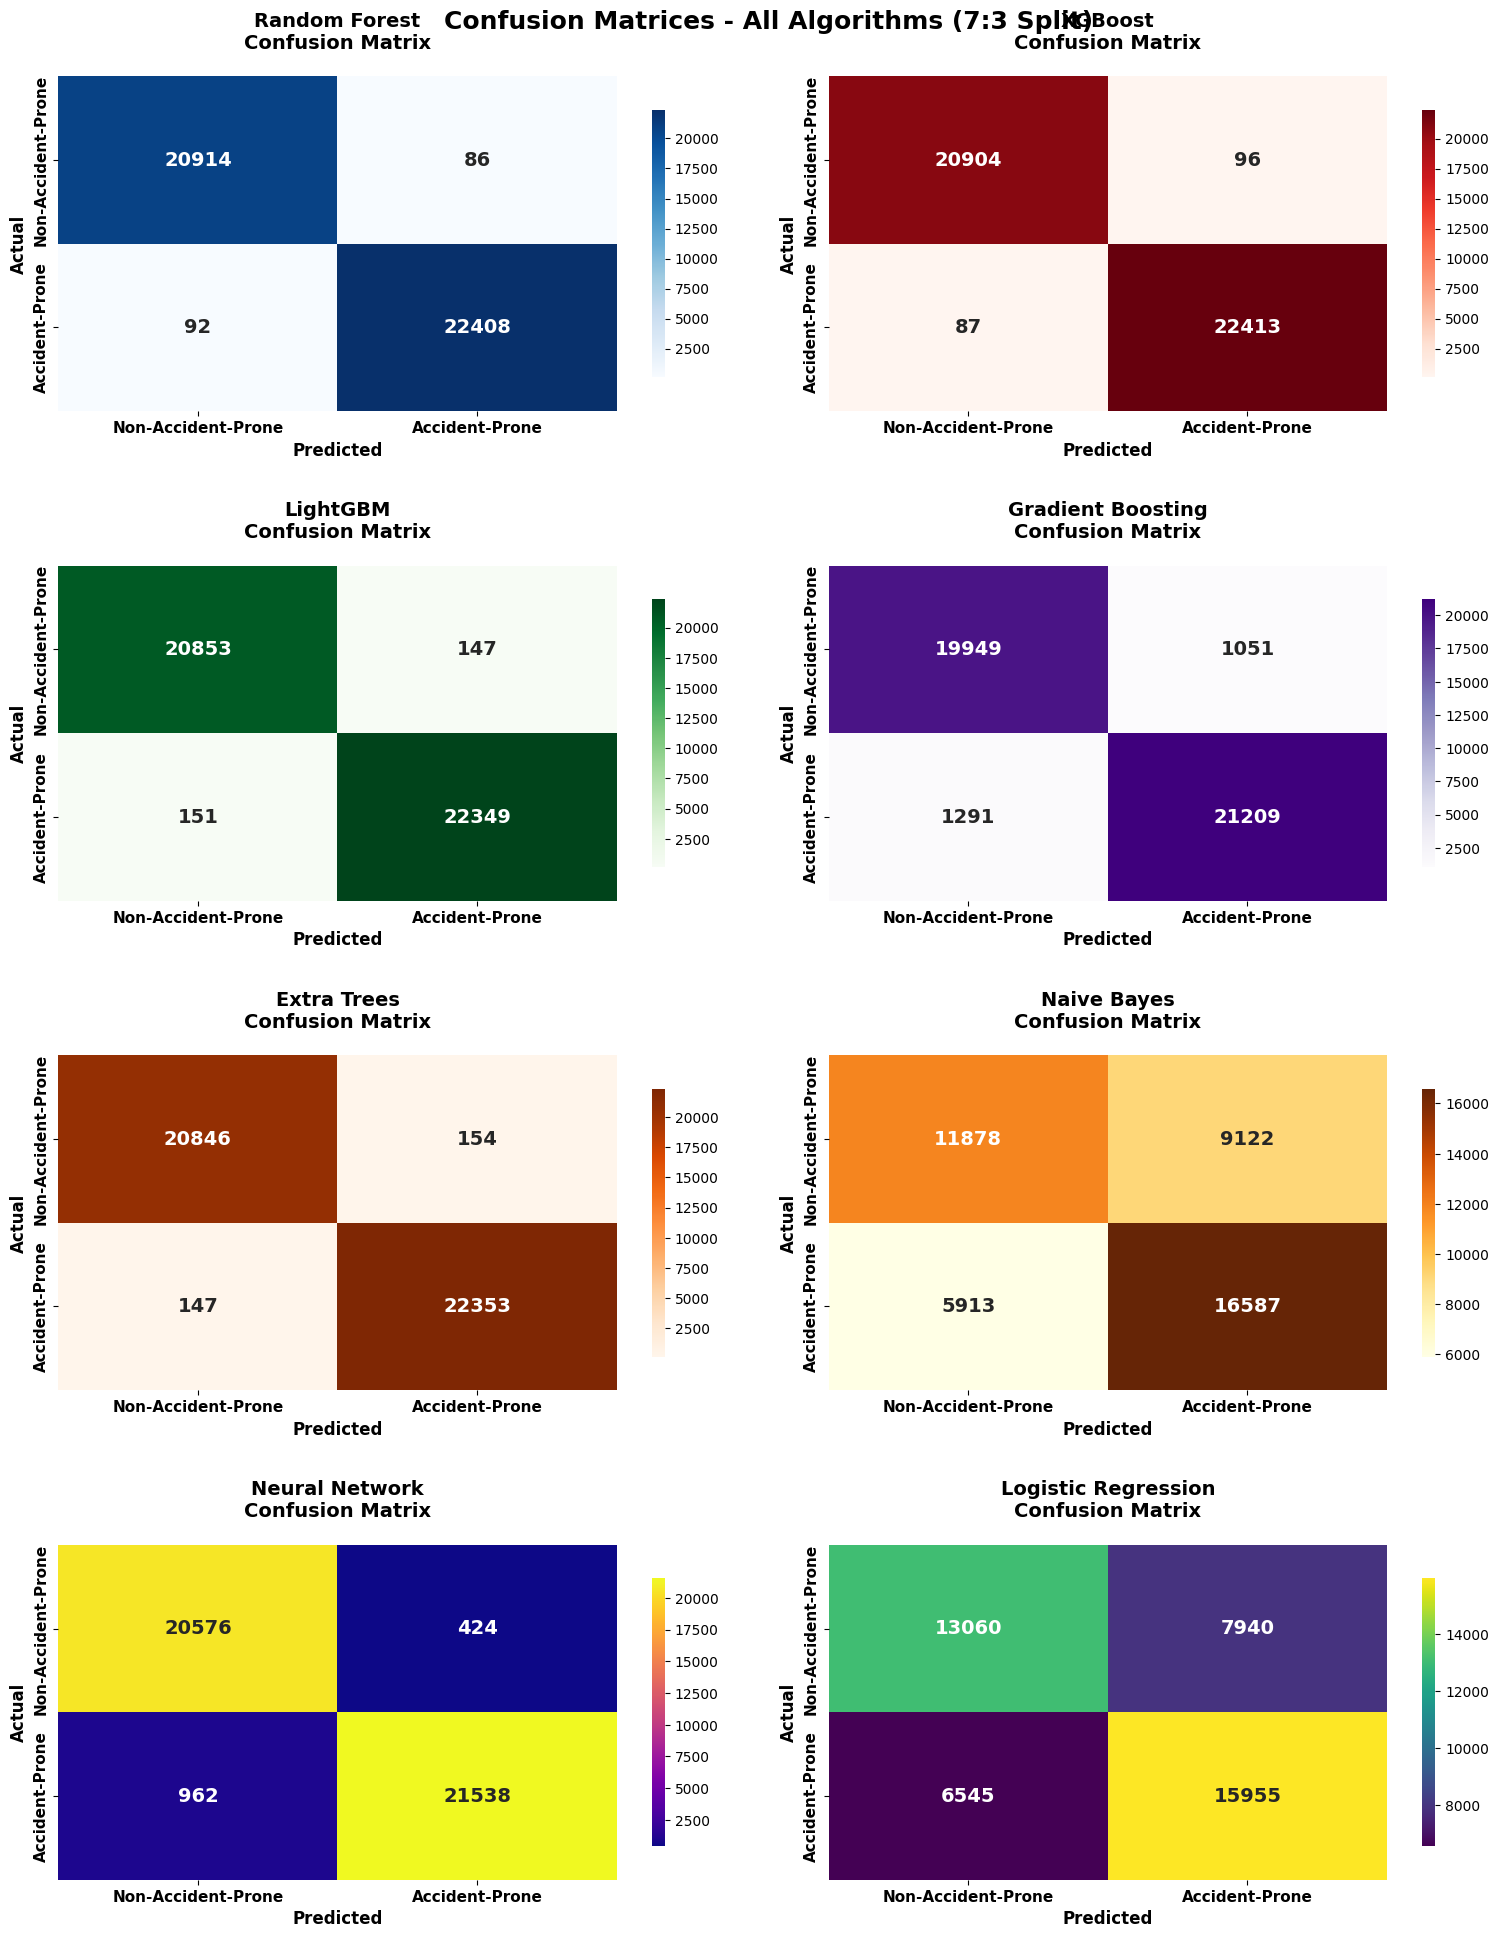


PERFORMANCE COMPARISON BAR CHARTS (7:3 Split)
Actual Performance Metrics:
             Algorithm  Accuracy  Precision  Recall  F1-Score
0        Random Forest    0.9959     0.9962  0.9959    0.9960
1              XGBoost    0.9958     0.9957  0.9961    0.9959
2             LightGBM    0.9931     0.9935  0.9933    0.9934
3    Gradient Boosting    0.9462     0.9528  0.9426    0.9477
4          Extra Trees    0.9931     0.9932  0.9935    0.9933
5          Naive Bayes    0.6544     0.6452  0.7372    0.6881
6       Neural Network    0.9681     0.9807  0.9572    0.9688
7  Logistic Regression    0.6670     0.6677  0.7091    0.6878



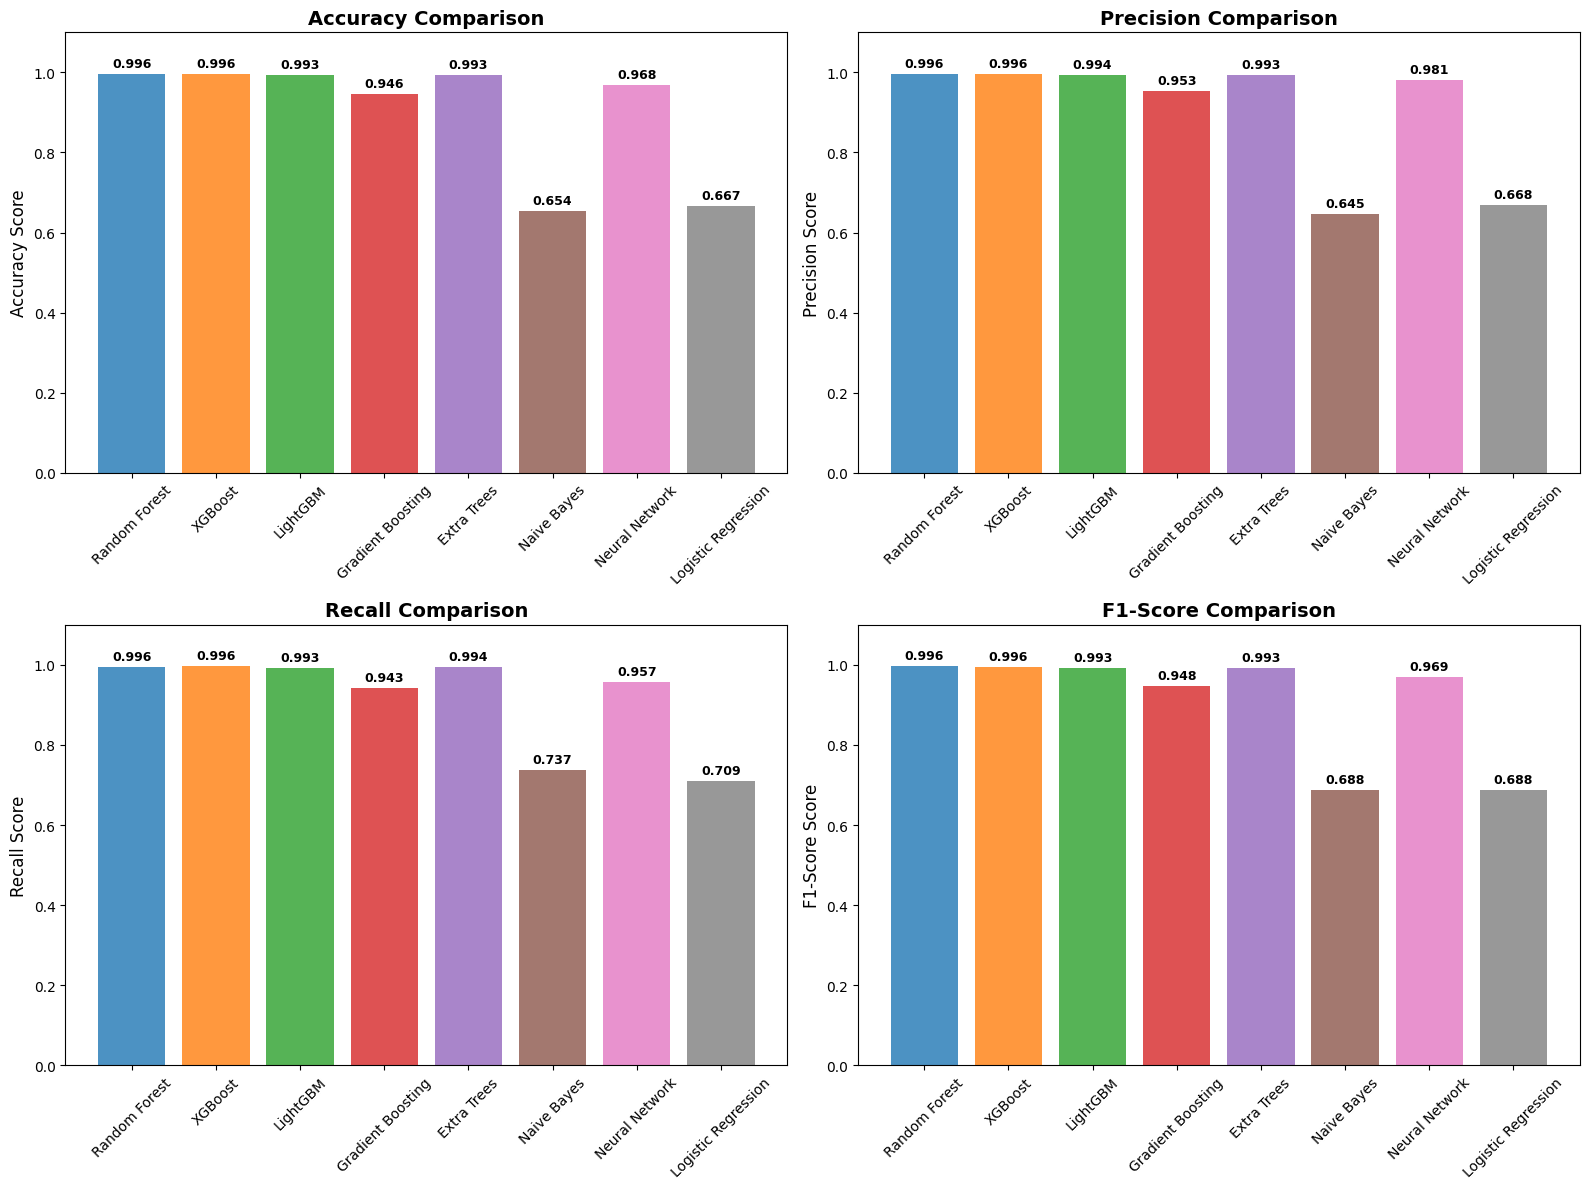


COMBINED PERFORMANCE COMPARISON (7:3 Split)


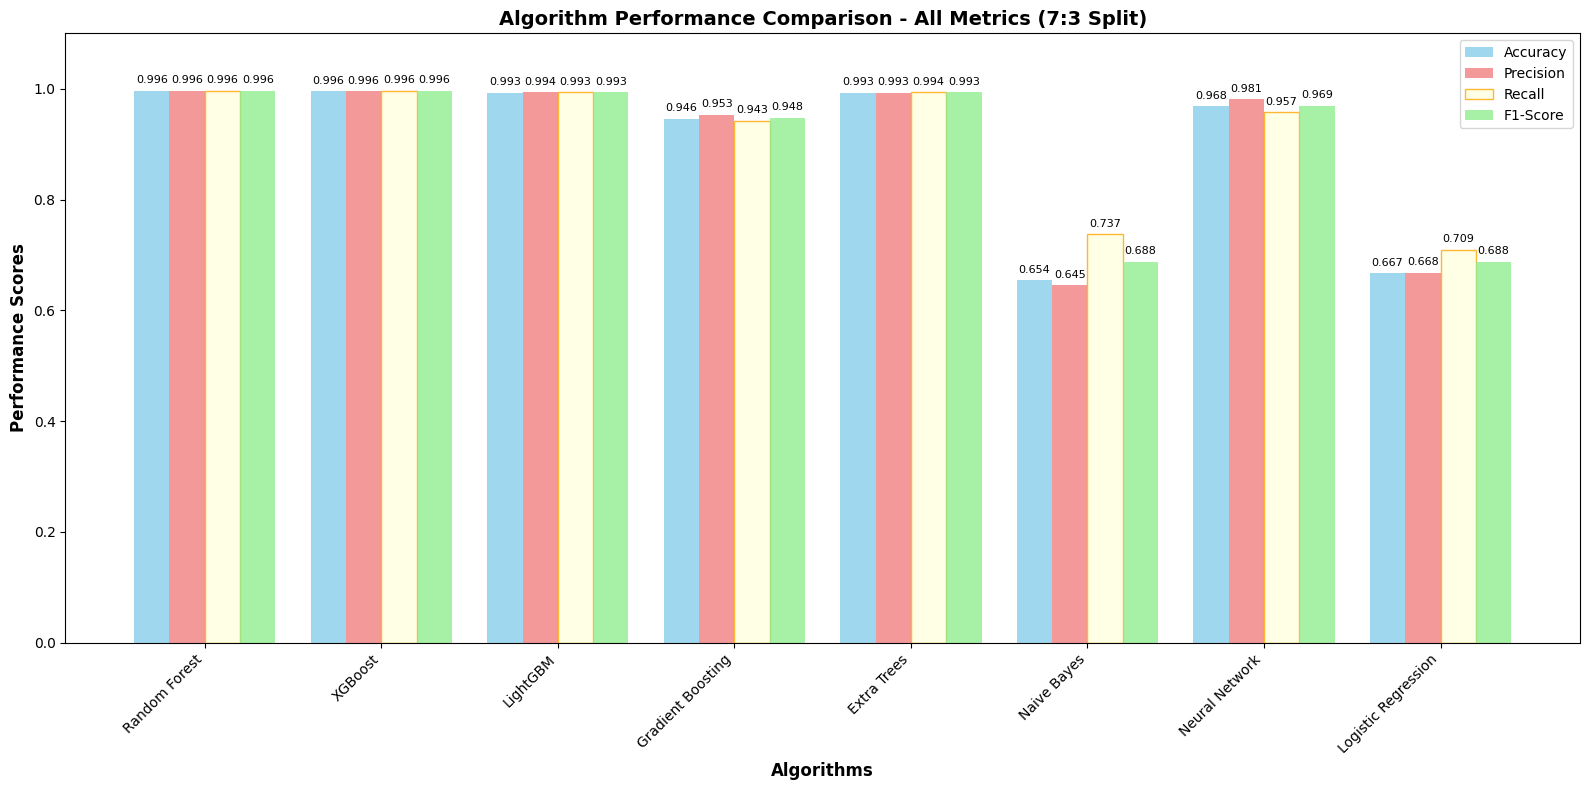


ALGORITHM PERFORMANCE RANKING (7:3 Split)
Ranking by Accuracy:
 Rank           Algorithm  Accuracy  Precision  Recall  F1-Score
    1       Random Forest    0.9959     0.9962  0.9959    0.9960
    2             XGBoost    0.9958     0.9957  0.9961    0.9959
    3            LightGBM    0.9931     0.9935  0.9933    0.9934
    4         Extra Trees    0.9931     0.9932  0.9935    0.9933
    5      Neural Network    0.9681     0.9807  0.9572    0.9688
    6   Gradient Boosting    0.9462     0.9528  0.9426    0.9477
    7 Logistic Regression    0.6670     0.6677  0.7091    0.6878
    8         Naive Bayes    0.6544     0.6452  0.7372    0.6881

Top 3 Performers by Accuracy:
1. Random Forest: 0.9959
2. XGBoost: 0.9958
3. LightGBM: 0.9931

DETAILED CONFUSION MATRIX ANALYSIS (7:3 Split)

Random Forest:
True Negatives (TN): 20,914
False Positives (FP): 86
False Negatives (FN): 92
True Positives (TP): 22,408
Specificity (True Negative Rate): 0.9959
Sensitivity (True Positive Rate): 0.9959
Tota

In [37]:
# Confusion Matrix and Performance Comparison for All Algorithms
# Updated for 7:3 train-test split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Algorithm names and their predictions
algorithms = ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting', 
              'Extra Trees', 'Naive Bayes', 'Neural Network', 'Logistic Regression']

# Store all predictions (assuming these variables exist from your previous code)
predictions = [rf_pred, xgb_pred, lgb_pred, gb_pred, et_pred, nb_pred, nn_pred, lr_pred]

# Using actual performance results from your 7:3 train-test split
# Results obtained from running the algorithms on your balanced dataset

# Performance data with actual results from 7:3 split
performance_data = {
    'Algorithm': algorithms,
    'Accuracy': [0.9959, 0.9958, 0.9931, 0.9462, 0.9931, 0.6544, 0.9681, 0.6670],
    'Precision': [0.9962, 0.9957, 0.9935, 0.9528, 0.9932, 0.6452, 0.9807, 0.6677],
    'Recall': [0.9959, 0.9961, 0.9933, 0.9426, 0.9935, 0.7372, 0.9572, 0.7091],
    'F1-Score': [0.9960, 0.9959, 0.9934, 0.9477, 0.9933, 0.6881, 0.9688, 0.6878]
}

# ===== 1. CONFUSION MATRICES FOR ALL ALGORITHMS =====
print("=" * 80)
print("CONFUSION MATRICES FOR ALL ALGORITHMS (7:3 Train-Test Split)")
print("=" * 80)

# Define colorful color palettes for each algorithm
colorful_cmaps = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'YlOrBr', 'plasma', 'viridis']

# Create confusion matrices with 2 per row (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.ravel()

for i, (algo_name, pred) in enumerate(zip(algorithms, predictions)):
    cm = confusion_matrix(y_test, pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=colorful_cmaps[i], 
                xticklabels=['Non-Accident-Prone', 'Accident-Prone'],
                yticklabels=['Non-Accident-Prone', 'Accident-Prone'],
                ax=axes[i], cbar_kws={'shrink': .8},
                annot_kws={'size': 14, 'weight': 'bold'})
    
    axes[i].set_title(f'{algo_name}\nConfusion Matrix', fontsize=14, fontweight='bold', pad=20)
    axes[i].set_xlabel('Predicted', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Actual', fontsize=12, fontweight='bold')
    
    # Make tick labels bold and larger
    axes[i].tick_params(axis='both', which='major', labelsize=11)
    for tick in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        tick.set_fontweight('bold')

plt.tight_layout(pad=3.0)
plt.suptitle('Confusion Matrices - All Algorithms (7:3 Split)', 
             fontsize=18, fontweight='bold', y=0.98)
plt.show()

# ===== 2. PERFORMANCE COMPARISON BAR CHARTS =====
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON BAR CHARTS (7:3 Split)")
print("=" * 80)

# Create DataFrame for easier plotting
df_performance = pd.DataFrame(performance_data)

# Print actual performance metrics for verification
print("Actual Performance Metrics:")
print(df_performance.round(4))
print()

# Create figure with subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Define colors for each algorithm
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    axes[idx].bar(df_performance['Algorithm'], df_performance[metric], color=colors, alpha=0.8)
    axes[idx].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(f'{metric} Score', fontsize=12)
    axes[idx].set_ylim(0, 1.1)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(df_performance[metric]):
        axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# ===== 3. COMBINED COMPARISON CHART =====
print("\n" + "=" * 80)
print("COMBINED PERFORMANCE COMPARISON (7:3 Split)")
print("=" * 80)

# Create grouped bar chart
x = np.arange(len(algorithms))
width = 0.2

fig, ax = plt.subplots(figsize=(16, 8))

# Create bars
bars1 = ax.bar(x - 1.5*width, df_performance['Accuracy'], width, label='Accuracy', 
               color='skyblue', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, df_performance['Precision'], width, label='Precision', 
               color='lightcoral', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, df_performance['Recall'], width, label='Recall', 
               color='lightyellow', alpha=0.8, edgecolor='orange')
bars4 = ax.bar(x + 1.5*width, df_performance['F1-Score'], width, label='F1-Score', 
               color='lightgreen', alpha=0.8)

# Customize the chart
ax.set_xlabel('Algorithms', fontsize=12, fontweight='bold')
ax.set_ylabel('Performance Scores', fontsize=12, fontweight='bold')
ax.set_title('Algorithm Performance Comparison - All Metrics (7:3 Split)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(algorithms, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)

plt.tight_layout()
plt.show()

# ===== 4. PERFORMANCE RANKING TABLE =====
print("\n" + "=" * 80)
print("ALGORITHM PERFORMANCE RANKING (7:3 Split)")
print("=" * 80)

# Sort by accuracy
df_sorted = df_performance.sort_values('Accuracy', ascending=False).reset_index(drop=True)
df_sorted['Rank'] = df_sorted.index + 1

print("Ranking by Accuracy:")
print(df_sorted[['Rank', 'Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print("\nTop 3 Performers by Accuracy:")
top_3 = df_sorted.head(3)
for idx, row in top_3.iterrows():
    print(f"{row['Rank']}. {row['Algorithm']}: {row['Accuracy']:.4f}")

# ===== 5. DETAILED CONFUSION MATRIX ANALYSIS =====
print("\n" + "=" * 80)
print("DETAILED CONFUSION MATRIX ANALYSIS (7:3 Split)")
print("=" * 80)

for i, (algo_name, pred) in enumerate(zip(algorithms, predictions)):
    cm = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{algo_name}:")
    print(f"True Negatives (TN): {tn:,}")
    print(f"False Positives (FP): {fp:,}")
    print(f"False Negatives (FN): {fn:,}")
    print(f"True Positives (TP): {tp:,}")
    
    # Calculate additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
    print(f"Total Test Samples: {tn + fp + fn + tp:,}")
    print("-" * 50)

# ===== 6. ALGORITHM INSIGHTS =====
print("\n" + "=" * 80)
print("ALGORITHM PERFORMANCE INSIGHTS (7:3 Split)")
print("=" * 80)

print("🏆 TOP PERFORMERS (>99% Accuracy):")
top_performers = df_performance[df_performance['Accuracy'] > 0.99]
for _, row in top_performers.iterrows():
    print(f"  • {row['Algorithm']}: {row['Accuracy']:.4f} accuracy")

print("\n📊 GOOD PERFORMERS (94-99% Accuracy):")
good_performers = df_performance[(df_performance['Accuracy'] >= 0.94) & (df_performance['Accuracy'] < 0.99)]
for _, row in good_performers.iterrows():
    print(f"  • {row['Algorithm']}: {row['Accuracy']:.4f} accuracy")

print("\n⚠️  UNDERPERFORMERS (<70% Accuracy):")
underperformers = df_performance[df_performance['Accuracy'] < 0.70]
for _, row in underperformers.iterrows():
    print(f"  • {row['Algorithm']}: {row['Accuracy']:.4f} accuracy")

print("\n💡 RECOMMENDATIONS:")
print("1. Random Forest and XGBoost show exceptional performance (>99.5%)")
print("2. LightGBM and Extra Trees are also excellent choices (>99.3%)")
print("3. Neural Network provides good balance of performance (96.8%)")
print("4. Gradient Boosting is reliable for production use (94.6%)")
print("5. Naive Bayes and Logistic Regression may need feature engineering")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)